## 1. Install Dependencies

In [1]:
# import opencv
import cv2 as cv
# import math functions
import math
from math import dist
import numpy as np
# import system libraries
import glob
import os
# import distance calculation libraries
import imutils
from imutils import perspective
# import data processing libraries
import pandas
# import pytorch
import torch
# import socket
from ast import Break
import imp
from multiprocessing.connection import answer_challenge, wait
import socket
import time
# import machine learning model configs
from distutils.version import LooseVersion
import mmcv
from mmcv import Config
from mmdet.datasets import build_dataset
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.mvtec import ScrewsDataset
from mmdet.apis import inference_detector, show_result_pyplot, set_random_seed

C:\Users\jense\AppData\Local\Temp\ipykernel_22108\3819040069.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\jense\anaconda3\envs\mmyolo\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


#### Miscallaneous Functions
*Nothing function is a dummy function for creating trackbars/number sliders*  
Trackbar code from: https://blog.electroica.com/trackbar-in-opencv-python/

In [2]:
def nothing(x): #dummy function for trackbar
    pass

In [3]:
def check_folder(folder_name): #makes new directory if it does not already exist
    path = os.path.join(os.getcwd(), folder_name)
    print(path)
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def clear_images(folder_name, image_start): #removes all specified images from folder
    path = os.path.join(os.getcwd(), folder_name)
    for fname in os.listdir(path):
        if fname.startswith(image_start):
            os.remove(os.path.join(path,fname))

## Section 3. Calibrate Camera  
Webcam code reference: https://stackoverflow.com/questions/34588464/python-how-to-capture-image-from-webcam-on-click-using-opencv  
Calibration code reference: https://learnopencv.com/camera-calibration-using-opencv/  
Opencv Calibration doc: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [5]:
def take_webcam_pics(num, folder_name):
    check_folder(folder_name)
    #clear_images(folder_name, "calibration_pic")
    
    webcamVideo = cv.VideoCapture(0)
    cv.namedWindow("webcam") # used to display camera feed
    
    print("press space to save an image")
    while num >= 1:
        ret, frame = webcamVideo.read()
        if not ret: # check if camera is working
            print("Camera off")
            break
            
        cv.imshow("feed", frame) # display camera feed
         
        k = cv.waitKey(1) & 0xFF #gets value of key pressed
        if k == 27: # esc key pressed
            print("Escape hit, closing...")
            break
        elif k == 32: # space key pressed
            image_path = os.path.join(os.getcwd(), folder_name, "calibration_pic_{}.jpg".format(num))
            cv.imwrite(image_path, frame)            
            print("saving image")
            num -= 1
    webcamVideo.release()
    cv.destroyAllWindows()      
        

In [6]:
def cam_cal(newpics = False): # determine if new cals are needed
    # Defining the dimensions of checkerboard
    CHECKERBOARD = (7,10) # checkerboard needs to be large enough to load
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = [] 
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = [] 

    # Defining the world coordinates for 3D points
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    # Extracting path of individual image stored in a given directory
    if(newpics): #
        take_webcam_pics(20, "calibs") #Take 20 pictures for calibration
    images = glob.glob('./calibs/*.jpg')
    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        # If desired number of corners are found in the image then ret = true
        ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, 
            cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        """
        If desired number of corner are detected,
        we refine the pixel coordinates and display them on the images of checker board
        """
        if ret == True:
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            #img = cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

        #cv.imshow('img',img) # show images
        #cv.waitKey(0)

    cv.destroyAllWindows()

    h,w = img.shape[:2]

    """
    Performing camera calibration by passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the detected corners (imgpoints)
    """
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # print calibration values
    """
    print("Camera matrix : \n")
    print(mtx)
    print("dist : \n")
    print(dist)
    print("rvecs : \n")
    print(rvecs)
    print("tvecs : \n")
    print(tvecs)
    """
    return ret, mtx, dist, rvecs, tvecs # return calibration values for future images

In [7]:
def undistort_img(img, mtx, dist):
    #img = cv.imread(img)
    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    #cv.imwrite('calibresult.png', dst)
    return dst

## 5. Import/Load Pytorch Model

In [8]:
model = torch.load("screw.pt")
cfg = Config.fromfile('./mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

cfg.data['workers_per_gpu']=0

# Modify dataset type and path
cfg.dataset_type = 'ScrewsDataset'
cfg.data_root = 'demo/screwdata/'

cfg.data.test.type = 'ScrewsDataset'
cfg.data.test.data_root = 'demo/screwdata/'
cfg.data.test.ann_file = 'val'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'ScrewsDataset'
cfg.data.train.data_root = 'demo/screwdata/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'ScrewsDataset'
cfg.data.val.data_root = 'demo/screwdata/'
cfg.data.val.ann_file = 'val'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 13
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

model.cfg = cfg

# Add an attribute for visualization convenience
datasets = [build_dataset(cfg.data.train)]
model.CLASSES = datasets[0].CLASSES

print(model.CLASSES) # check for screws dataset classes

model.eval()

('long_lag_screw', 'lag_wood_screw', 'wood_screw', 'short_wood_screw', 'shiny_screw', 'black_oxide_screw', 'nut', 'bolt', 'large_nut', 'nut', 'nut', 'machine_screw', 'short_machine_screw')


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

extracting bounding box details: https://vinleonardo.com/detecting-objects-in-pictures-and-extracting-their-data-using-mmdetection/

In [9]:
# Individual Image Testing
#img = mmcv.imread('mmrotate/demo/screwdata/images/screws_210.png')
#model.cfg = cfg
#result = inference_detector(model, img)
#show_result_pyplot(model, img, result, score_thr=0.3)

def parse_bbox(result):
    bbox_result = result
    # if instance segmentation
    # bbox_result, segm_result = result
    labels = [np.full(bbox.shape[0], i, dtype=np.int32) for i, bbox in enumerate(bbox_result)]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    labels_impt = np.where(bboxes[:, -1] > 0.3)[0]

    classes = model.CLASSES
    labels_impt_list = [labels[i] for i in labels_impt]
    labels_class = [classes[i] for i in labels_impt_list]

    index = 0;
    threshold = -1;
    for i, bbox in enumerate(bboxes[labels_impt]):
        print(i, bbox)
        if bbox[i] > threshold:
            threshold = bbox[i]
            index = i
    if threshold == -1:
        return "null", 0, 0, 0, 0, 0, -1
    lbl = labels_class[i]
    cx = bboxes[labels_impt][i][0]
    cy = bboxes[labels_impt][i][1]
    width = bboxes[labels_impt][i][2]
    height = bboxes[labels_impt][i][3]
    rotation = bboxes[labels_impt][i][4]
    rotation = math.degrees(rotation)
    threshold = bboxes[labels_impt][i][5]
    print(lbl, cx, cy, rotation, threshold)
    return lbl, cx, cy, width, height, rotation, threshold

#print(lbl, cx, cy, width, height, rotation, threshold)
#print(bboxes)

# Extra testing 

#from matplotlib import image
#from matplotlib import pyplot as plt
  
# to read the image stored in the working directory
#data = image.imread('mmrotate/demo/screwdata/images/screws_210.png')
  
#lbl, cx, cy, width, height, rotation, threshold = parse_bbox(result)
#plt.plot(cx, cy, marker='o', color="red")
#plt.plot([cx-width/2, cx+width/2], [cy, cy], color="white", linewidth=2)
#plt.plot([cx, cx], [cy-height/2, cy+height/2], color="white", linewidth=2)
#plt.imshow(data)
#plt.show()


## Section 6. Socket Definition

Socket information https://realpython.com/python-sockets/

In [10]:
IP = socket.gethostbyname(socket.gethostname())
IP_2 = "127.0.0.1" # Yumi IP address/ 192.168.125.1 (localhost)
print(IP)
# print(IP_2)

PORT = 4455
ADDR = (IP,PORT)
Format = "utf-8"
Size = 1024

192.168.0.170


## Section 6. Main  Function

In [ ]:
from multiprocessing import Process, Queue
from multiprocessing.shared_memory import SharedMemory
from multiprocessing.managers import BaseManager
from queue import LifoQueue
import time
import os  
    
def socket_connection(queue):    
    with conn: # with a connection
        print(f"\033[33m[NEW CONNECTION]\033[0m {addr} connected.")
        client_message = ""
        while True:
            client_message = connection.recv(Size).decode(Format) # read message to string
            print("Client Message has been received: ", client_message)
            if client_message == "Stop":
                break
            imgcopy = queue.get()
            server_message = get_bbox(imgcopy)
            for i in range(len(server_message)):
                temp_str = server_message[i]
                connection.sendto(str.encode(temp_str,Format),addr)
                time.sleep(.25)
        conn.close()
        
def get_bbox(img):
    result = inference_detector(model, img) #Run image detection
    #print(result)
    show_result_pyplot(model, img, result, score_thr=0.3)
    lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
    server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
    print(server_message)
    return server_message
        
def produce_frames(original, undist):
    #get the first frame to calculate size of buffer
    cap = cv.VideoCapture(0)
    success, frame = cap.read()
    shm = SharedMemory(create=True, size=frame.nbytes)
    framebuffer = np.ndarray(frame.shape, frame.dtype, buffer=shm.buf) #could also maybe use array.array instead of numpy, but I'm familiar with numpy
    framebuffer[:] = frame #in case you need to send the first frame to the main process
    original.put(shm) #send the buffer back to main
    original.put(frame.shape) #send the array details
    original.put(frame.dtype)
    
    undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
    undist.put(shm)
    try:
        while True:
            cap.read(framebuffer)
    except KeyboardInterrupt:
        pass
    finally:
        shm.close() #call this in all processes where the shm exists
        shm.unlink() #call from only one process

def consume_frames(original, undist):
    shm = original.get() #get the shared buffer
    shape = original.get()
    dtype = original.get()
    frame = np.ndarray(shape, dtype, buffer=shm.buf) #reconstruct the array
    try:
        while True:
            undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
            imgcopy = undist_frame.copy() # copy undistorted image for any processing
            cv.imshow("dist_feed", frame) # display undistorted camera feed
            cv.imshow("undist_feed", imgcopy) # display undistorted camera feed
            cv.waitKey(100)
    except KeyboardInterrupt:
        pass
    finally:
        shm.close()

# create manager that knows how to create and manage LifoQueues
class MyManager(BaseManager):
    pass
MyManager.register('LifoQueue', LifoQueue)
    
cal_needed = False
if(os.listdir(".\calibs") == []):
    cal_needed = True
#print(os.listdir(".\calibs"))
ret, mtx, dist, rvecs, tvecs = cam_cal(cal_needed) # calibrate camera


def main():
    print(f"\033[33m[Starting]\033[0m Server is starting.")
    server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server.bind(ADDR)
    server.listen()
    
    print(f"\033[33m[Listening]\033[0m Server is listening.")
    conn, addr = server.accept()
    print("test")
    manager = MyManager()
    manager.start()
    print("test1")
    original = manager.LifoQueue()
    undist = manager.LifoQueue()
    print("test2")
    camera = Process(target=produce_frames, args=(original, undist))
    camera.start()
    print("test3")
    sckt = Process(target=socket_connection, args=(undist, ))
    sckt.start()
    print("test4")
    consume_frames(original, undist)
    print("test5")
    
main()

[Starting] Server is starting.
[Listening] Server is listening.
test


[Starting] Server is starting.
[Listening] Server is listening.
[NEW CONNECTION] ('192.168.0.170', 65354) connected.
Client Message has been received:  Ready


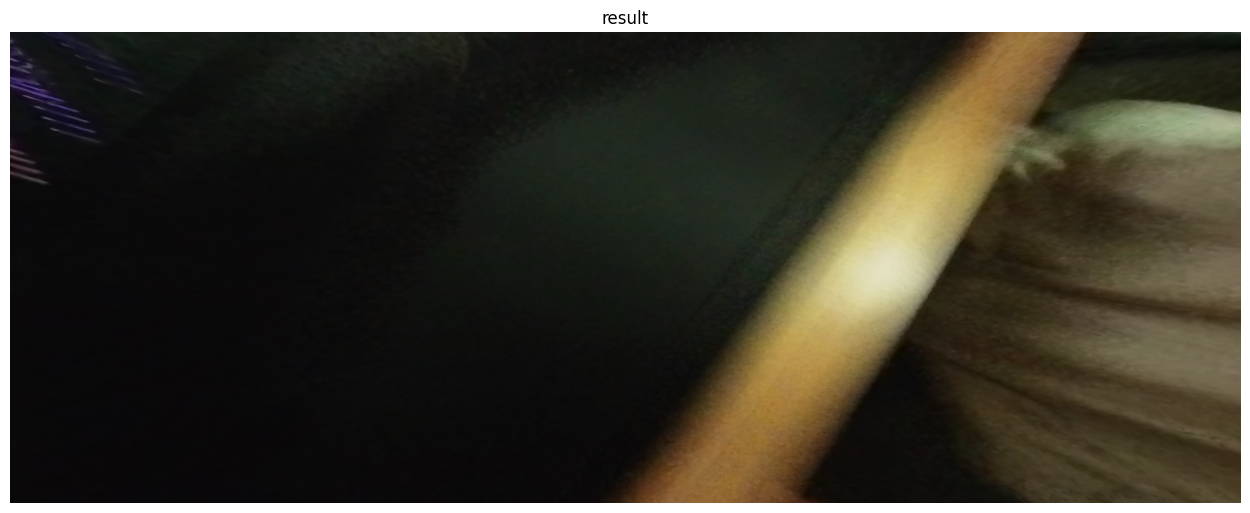

['0', '0', '0', 'null', 'Done']
Client Message 2 has been received:  Stop


In [15]:
cal_needed = False
if(os.listdir(".\calibs") == []):
    cal_needed = True
#print(os.listdir(".\calibs"))
ret, mtx, dist, rvecs, tvecs = cam_cal(cal_needed) # calibrate camera

# Start active video capture
webcamVideo = cv.VideoCapture(0)
#cv.namedWindow("webcam") # used to display camera feed

# Socket Info
client_message = "" # Reset client message
print(f"\033[33m[Starting]\033[0m Server is starting.")
server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.bind(ADDR)
server.listen()

# Main Function 
while client_message != "Stop":
    server_message = [] # Reset server message
    
    # Webcam start
    ret, frame = webcamVideo.read()
    undist_frame = undistort_img(frame, mtx, dist) # apply camera calibration
    imgcopy = undist_frame.copy() # copy undistorted image for any processing
    
    if ret: # if webcam video works
        #cv.imshow("frame", frame) #show distorted frame
    else:
        print('no video')
        webcamVideo.set(cv.CAP_PROP_POS_FRAMES, 0)
        continue
    
    # Client connected  
    print(f"\033[33m[Listening]\033[0m Server is listening.")
    conn, addr = server.accept() 

    with conn: # with a connection
        print(f"\033[33m[NEW CONNECTION]\033[0m {addr} connected.")
        client_message = conn.recv(Size).decode(Format) # read message to string
        print("Client Message has been received: ", client_message)
        if client_message == "Next":
            continue
        if client_message == "Stop":
            break
        if client_message == "Ready" :
            result = inference_detector(model, imgcopy) #Run image detection
            #print(result)
            show_result_pyplot(model, imgcopy, result, score_thr=0.3)
            lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
            server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
            print(server_message)
            for i in range(len(server_message)):
                temp_str = server_message[i]
                conn.sendto(str.encode(temp_str,Format),addr)
                time.sleep(.25)
            client_message = ""
            time.sleep(.25)
        client_message = conn.recv(Size).decode(Format) # read message to string
        print("Client Message 2 has been received: ", client_message)
    conn.close()
    #result = inference_detector(model, imgcopy) #Run image detection
    #lbl, cx, cy, width, height, theta, threshold = parse_bbox(result)
    #server_message = [str(cx), str(cy), str(theta), lbl, "Done"]
    #print(server_message)
    #cv.imshow("undist_feed", imgcopy) # display undistorted camera feed 
    
    k = cv.waitKey(1) & 0xFF #gets value of key pressed
    if k == 27: # esc key pressed
        print("Escape hit, closing...")
        break

webcamVideo.release()
cv.destroyAllWindows()      